In [4]:
# evaluate_cvae.ipynb - Cell 1

# --- Make sure to install the necessary libraries ---
# !pip install torchmetrics monai scikit-image

import sys
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

# --- Metrics (GPU-accelerated) ---
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from monai.metrics import DiceMetric

# --- Image Processing ---
from skimage.filters import threshold_otsu
from skimage.morphology import opening, ball
from skimage.measure import label

# --- Configuration ---
project_root = Path.cwd()
MODEL_PATH = project_root / "model_runs/cvae_run_3/best_cvae_model.pth"
DATA_DIR = Path("/mnt/hot/public/Akul/exhale_pred_data")
BATCH_SIZE = 64 
NUM_WORKERS = 8 
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LUNG_THRESHOLD = 0.1

print(f"Using device: {DEVICE}")
print(f"Loading model from: {MODEL_PATH}")

Using device: cuda:0
Loading model from: /home/dmic/Fibrosis/Akul/exhale_pred/model_runs/cvae_run_3/best_cvae_model.pth


In [5]:
# evaluate_cvae.ipynb - Cell 2

# --- CORRECT Model Architecture Definitions ---
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels)
            )
            
    def forward(self, x):
        identity = self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)

class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim=256, condition_size=128):
        super(ConditionalVAE, self).__init__()
        self.latent_dim = latent_dim
        self.condition_size = condition_size
        self.encoder = nn.Sequential(
            ResidualBlock(2, 32, stride=2),
            ResidualBlock(32, 64, stride=2),
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 256, stride=2),
        )
        self.fc_mu = nn.Linear(8 * 8 * 8 * 256, latent_dim)
        self.fc_var = nn.Linear(8 * 8 * 8 * 256, latent_dim)
        self.condition_encoder = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=4, stride=2, padding=1), nn.LeakyReLU(0.2),
            nn.Conv3d(16, 32, kernel_size=4, stride=2, padding=1), nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool3d((1, 1, 1)), nn.Flatten(), nn.Linear(32, self.condition_size)
        )
        self.decoder_input = nn.Linear(latent_dim + self.condition_size, 8 * 8 * 8 * 256)
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(256, 128, kernel_size=4, stride=2, padding=1), nn.BatchNorm3d(128), nn.ReLU(),
            nn.ConvTranspose3d(128, 64, kernel_size=4, stride=2, padding=1), nn.BatchNorm3d(64), nn.ReLU(),
            nn.ConvTranspose3d(64, 32, kernel_size=4, stride=2, padding=1), nn.BatchNorm3d(32), nn.ReLU(),
            nn.ConvTranspose3d(32, 1, kernel_size=4, stride=2, padding=1), nn.Sigmoid()
        )
    def encode(self, x, y):
        combined = torch.cat([x, y], dim=1)
        result = self.encoder(combined)
        result = torch.flatten(result, start_dim=1)
        return self.fc_mu(result), self.fc_var(result)
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    def decode(self, z, y):
        processed_condition = self.condition_encoder(y)
        combined_latent = torch.cat([z, processed_condition], dim=1)
        result = self.decoder_input(combined_latent)
        result = result.view(-1, 256, 8, 8, 8)
        return self.decoder(result)
    def forward(self, x, y):
        mu, log_var = self.encode(x, y)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decode(z, y)
        return recon_x, mu, log_var

# --- Dataset Class ---
class PairedLungDataset(Dataset):
    def __init__(self, data_dir: Path):
        self.inhale_dir = data_dir / "inhale"
        self.exhale_dir = data_dir / "exhale"
        self.mask_dir = data_dir / "masks" / "exhale"
        if not self.mask_dir.exists():
            raise FileNotFoundError(f"Mask directory not found at {self.mask_dir}.")
        all_patient_ids = sorted([f.stem for f in self.inhale_dir.glob("*.npy")])
        self.patient_ids = [pid for pid in all_patient_ids if (self.exhale_dir / f"{pid}.npy").exists() and (self.mask_dir / f"{pid}_EXP_mask.npy").exists()]
        print(f"Found {len(all_patient_ids)} total scans, using {len(self.patient_ids)} complete scan-mask pairs.")
    def __len__(self):
        return len(self.patient_ids)
    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]
        inhale_path = self.inhale_dir / f"{patient_id}.npy"
        exhale_path = self.exhale_dir / f"{patient_id}.npy"
        mask_path = self.mask_dir / f"{patient_id}_EXP_mask.npy"
        
        inhale_scan = torch.from_numpy(np.load(inhale_path).astype(np.float32)[np.newaxis, ...])
        exhale_scan = torch.from_numpy(np.load(exhale_path).astype(np.float32)[np.newaxis, ...])
        exhale_mask = torch.from_numpy((np.load(mask_path).astype(np.float32) > 0).astype(np.float32)[np.newaxis, ...])

        return exhale_scan, inhale_scan, exhale_mask

# --- Robust Segmentation Function ---
def segment_lungs_robust(image_tensor):
    img_np = image_tensor.cpu().numpy().squeeze()
    thresh = threshold_otsu(img_np)
    mask = img_np > thresh
    footprint = ball(2)
    mask = opening(mask, footprint)
    labels = label(mask)
    if labels.max() != 0:
        largest_label = np.argmax(np.bincount(labels.flat)[1:]) + 1
        mask = labels == largest_label
    return torch.from_numpy(mask.astype(np.float32)).to(image_tensor.device)

--- Loading Model ---


/tmp/ipykernel_97956/2373726225.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(MODEL_PATH, map_location=DEVICE)


Model loaded successfully.
Found 8702 total scans, using 8701 complete scan-mask pairs.

--- Visually Verifying Robust Segmentation ---


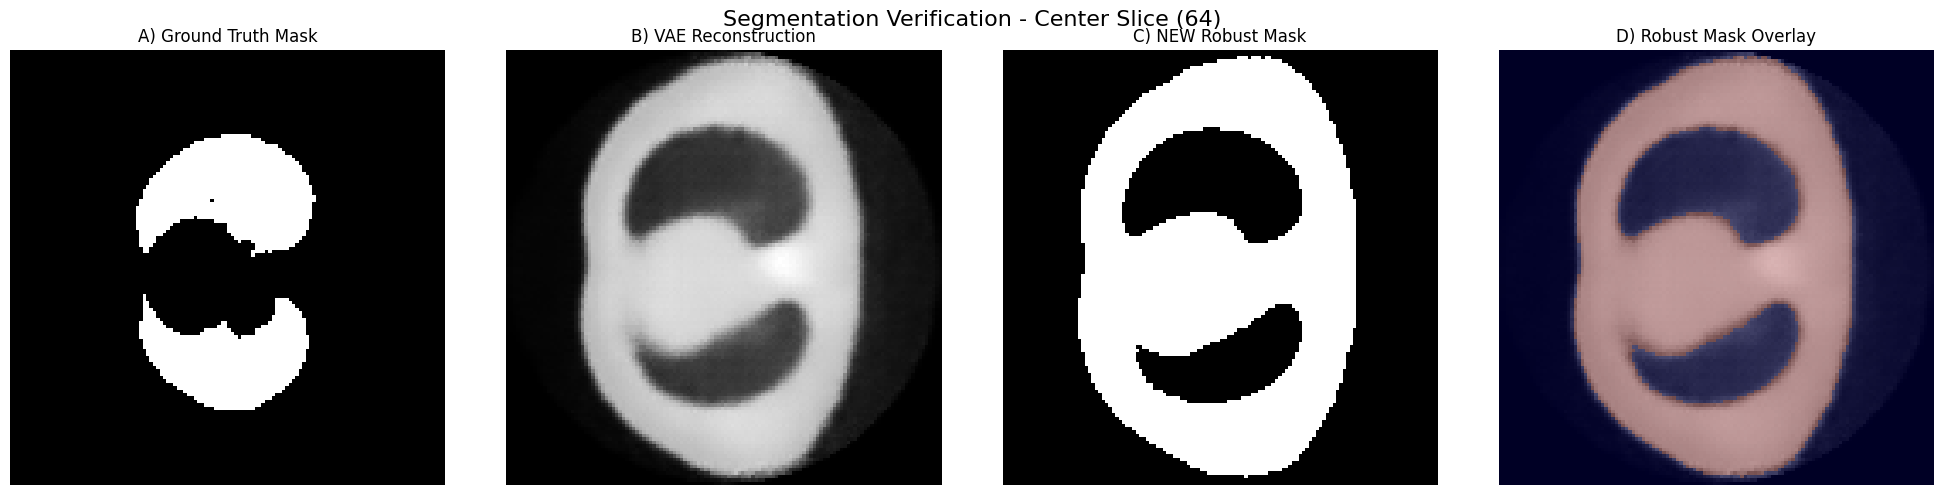

In [6]:
# evaluate_cvae.ipynb - Cell 3

# --- 1. Load the trained CVAE model ---
print("--- Loading Model ---")
model = ConditionalVAE(latent_dim=256, condition_size=128)
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
if list(state_dict.keys())[0].startswith('module.'):
    state_dict = {k[7:]: v for k, v in state_dict.items()}
model.load_state_dict(state_dict)
model.to(DEVICE)
model.eval()
print("Model loaded successfully.")

# --- 2. Create the DataLoader ---
val_dataset = PairedLungDataset(DATA_DIR)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

# --- 3. Visually Verify Segmentation Output ---
print("\n--- Visually Verifying Robust Segmentation ---")
try:
    real_exhale, real_inhale, real_mask_gt = next(iter(val_loader))
    idx = random.randint(0, real_exhale.shape[0] - 1)
    sample_exhale, sample_inhale, sample_mask_gt_np = real_exhale[idx:idx+1].to(DEVICE), real_inhale[idx:idx+1].to(DEVICE), real_mask_gt[idx].cpu().numpy()[0]

    with torch.no_grad():
        recon_exhale_tensor, _, _ = model(sample_exhale, sample_inhale)
    
    pred_mask_robust_np = segment_lungs_robust(recon_exhale_tensor[0]).cpu().numpy()
    recon_exhale_np = recon_exhale_tensor[0].cpu().numpy()[0]

    center_slice_idx = recon_exhale_np.shape[0] // 2
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f"Segmentation Verification - Center Slice ({center_slice_idx})", fontsize=16)
    axes[0].imshow(sample_mask_gt_np[:, :, center_slice_idx], cmap='gray'); axes[0].set_title("A) Ground Truth Mask"); axes[0].axis('off')
    axes[1].imshow(recon_exhale_np[:, :, center_slice_idx], cmap='gray'); axes[1].set_title("B) VAE Reconstruction"); axes[1].axis('off')
    axes[2].imshow(pred_mask_robust_np[:, :, center_slice_idx], cmap='gray'); axes[2].set_title("C) NEW Robust Mask"); axes[2].axis('off')
    axes[3].imshow(recon_exhale_np[:, :, center_slice_idx], cmap='gray'); axes[3].imshow(pred_mask_robust_np[:, :, center_slice_idx], cmap='jet', alpha=0.3); axes[3].set_title("D) Robust Mask Overlay"); axes[3].axis('off')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred during visualization: {e}")

# Re-define the val_loader for the final evaluation to ensure it's not shuffled
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

In [7]:
model = ConditionalVAE(latent_dim=256, condition_size=128)
# Handle model weights saved with DDP 'module.' prefix
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
if list(state_dict.keys())[0].startswith('module.'):
    state_dict = {k[7:]: v for k, v in state_dict.items()}
model.load_state_dict(state_dict)
model.to(DEVICE)
model.eval()

val_dataset = PairedLungDataset(DATA_DIR)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


/tmp/ipykernel_97956/929161437.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(MODEL_PATH, map_location=DEVICE)


Found 8702 total scans, using 8701 complete scan-mask pairs.


In [9]:
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(DEVICE)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(DEVICE)
dice_metric = DiceMetric(include_background=True, reduction="mean")
psnr_scores, ssim_scores, volume_diffs, mae_lung_scores = [], [], [], []

with torch.no_grad():
    for real_exhale, real_inhale, real_mask_gt in tqdm(val_loader, desc="Evaluating Model"):
        real_exhale, real_inhale, real_mask_gt = real_exhale.to(DEVICE), real_inhale.to(DEVICE), real_mask_gt.to(DEVICE)
        with torch.amp.autocast('cuda'):
            recon_exhale, _, _ = model(real_exhale, real_inhale)
            psnr_scores.append(psnr_metric(recon_exhale, real_exhale).item())
            ssim_scores.append(ssim_metric(recon_exhale, real_exhale).item())
            recon_mask = torch.stack([segment_lungs_robust(img[0]) for img in recon_exhale]).unsqueeze(1)
            dice_metric(y_pred=recon_mask, y=real_mask_gt)
            for i in range(real_exhale.shape[0]):
                real_mask = real_mask_gt[i]
                real_volume = torch.sum(real_mask).item()
                recon_volume = torch.sum(recon_mask[i]).item()
                vol_diff = 100 * abs(recon_volume - real_volume) / real_volume if real_volume > 0 else 0
                volume_diffs.append(vol_diff)
                mae_lung = torch.mean(torch.abs(real_exhale[i][real_mask.bool()] - recon_exhale[i][real_mask.bool()])).item()
                mae_lung_scores.append(mae_lung)

mean_dice = dice_metric.aggregate().item()


Evaluating Model: 100%|██████████| 136/136 [30:26<00:00, 13.43s/it]


In [12]:
print("\n--- CVAE Evaluation Results ---")
print(f"Evaluated on {len(psnr_scores)} scan pairs using ground-truth segmentation masks.")
    
print("\n--- Pixel-Level Fidelity ---")
print(f"  - Average PSNR: {np.mean(psnr_scores):.2f} ± {np.std(psnr_scores):.2f} ↑")
print(f"  - Average SSIM: {np.mean(ssim_scores):.3f} ± {np.std(ssim_scores):.3f} ↑")
print("\n--- Structural & Volumetric Fidelity (Clinically-Oriented) ---")
print(f"  - Average Dice Score (DSC): {mean_dice:.3f} ↑")
print(f"  - Average Lung Volume Difference: {np.mean(volume_diffs):.2f}% ± {np.std(volume_diffs):.2f}% ↓")
print(f"  - Average MAE in Lung Mask: {np.mean(mae_lung_scores):.4f} ± {np.std(mae_lung_scores):.4f} ↓")
print("---------------------------------\n")


--- CVAE Evaluation Results ---
Evaluated on 136 scan pairs using ground-truth segmentation masks.

--- Pixel-Level Fidelity ---
  - Average PSNR: 15.18 ± 0.17 ↑
  - Average SSIM: 0.441 ± 0.018 ↑

--- Structural & Volumetric Fidelity (Clinically-Oriented) ---
  - Average Dice Score (DSC): 0.106 ↑
  - Average Lung Volume Difference: 494.55% ± 235.77% ↓
  - Average MAE in Lung Mask: 0.1819 ± 0.0397 ↓
---------------------------------

